**Importation des libraires**

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


**Acquérir les données et créer le Dataframe**

**A) Scrapping :**

Identification des critères de recherches afin d'avoir plus d'informations. Collecter les données nécessaires permettant de prédire le prix futur et la production fututre des tomates.

**B) Description des données:**

Au total, il y a 425 observations et 11 variables qualitatives. Les données sont:

la date
le prix moyen au kg
le prix minimal
le prix maximal
la température minimale en °C
la température maximale en °C
le taux de précipitations en mm
l'ensoleillement en min
la vitesse du vent en km/h
la catégorie de la tomate

In [2]:
Pop = pd.read_csv("/content/Tomates+météo - Sheet1 (1).csv")

Pop

,Date,prix moyen au kg,prix minimal,prix maximal,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
0,21/06/21,1.50,1.5,1.5,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm
1,04/12/20,1.50,NaN,NaN,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm
2,06/11/20,1.10,NaN,NaN,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm
3,05/11/20,1.10,NaN,NaN,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm
4,30/10/20,1.05,1.0,1.1,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.1,1.1,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm
420,20/06/13,1.50,1.5,1.5,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm
421,17/06/13,1.50,1.5,1.5,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm
422,18/09/12,1.10,1.1,1.1,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm


In [3]:
Pop.shape

(424, 11)

In [4]:
Pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               424 non-null    object 
 1   prix moyen au kg                   421 non-null    float64
 2   prix minimal                       377 non-null    float64
 3   prix maximal                       377 non-null    float64
 4   Production quantité 
tonne(s)      424 non-null    float64
 5   Température minimale en °C         424 non-null    float64
 6   Température maximale en °C         424 non-null    float64
 7   précipitations en mm               424 non-null    float64
 8   Ensoleillement en min              424 non-null    int64  
 9   Rafales (vitesse du vent) en km/h  424 non-null    float64
 10  catégorie tomates                  424 non-null    object 
dtypes: float64(8), int64(1), object(2)
memory usage: 36.6+ KB


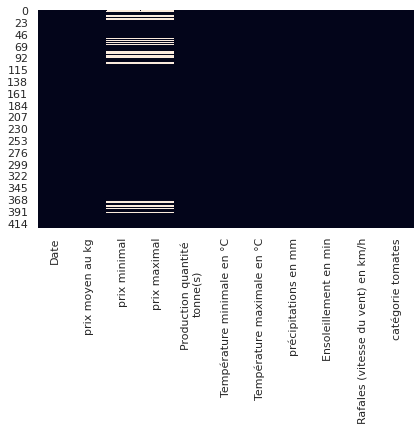

In [5]:
sns.heatmap(Pop.isna(), cbar=False) #Pour visualiser les valeurs nulles

In [6]:
def nan_description(Pop):
    total = Pop.isnull().sum().sort_values(ascending=False)
    percent = (Pop.isnull().sum()/Pop.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pourcentage'])
    return missing_data.head(20)

nan_description(Pop)

,Total,Pourcentage
prix maximal,47,0.110849
prix minimal,47,0.110849
prix moyen au kg,3,0.007075
catégorie tomates,0,0.000000
Rafales (vitesse du vent) en km/h,0,0.000000
Ensoleillement en min,0,0.000000
précipitations en mm,0,0.000000
Température maximale en °C,0,0.000000
Température minimale en °C,0,0.000000
Production quantité \ntonne(s),0,0.000000


In [7]:
Pop = Pop.drop(["prix maximal","prix minimal"], axis=1)
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm


On a retiré les colonnes "prix maximal" et "prix minimal".

**Analyse des données**

In [8]:
Pop.describe()

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
count,421.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,1.264798,0.464830,12.051651,23.908726,1.475236,436.160377,40.075472
std,0.288990,0.776784,3.965298,5.803186,4.417398,266.967955,12.427627
min,0.500000,0.016000,-0.100000,6.600000,0.000000,0.000000,14.400000
25%,1.050000,0.100000,9.800000,20.100000,0.000000,210.000000,31.500000
50%,1.200000,0.240000,12.300000,23.700000,0.000000,447.500000,38.900000
75%,1.500000,0.500000,14.700000,28.000000,0.400000,658.500000,46.800000
max,2.000000,7.680000,23.200000,41.300000,31.900000,906.000000,92.600000


**Analyse du prix et de la production**

In [9]:
Pop['prix moyen au kg'].describe()

count    421.000000
mean       1.264798
std        0.288990
min        0.500000
25%        1.050000
50%        1.200000
75%        1.500000
max        2.000000
Name: prix moyen au kg, dtype: float64

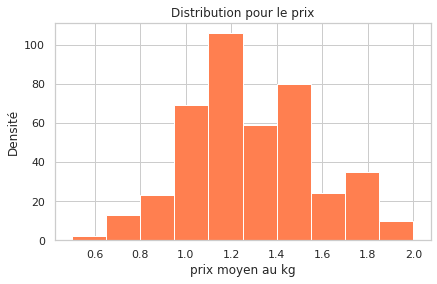

skew= 0.22827047693351454


In [10]:
plt.hist(Pop['prix moyen au kg'],color ='coral')
plt.title('Distribution pour le prix')
plt.xlabel('prix moyen au kg')
plt.ylabel('Densité')
plt.show()
print ("skew=", Pop['prix moyen au kg'].skew())

On remarque que le prix moyen en moyenne est d'environ 1.26 € au kilo, avec des valeurs comprises entre 0.50 € et 2 €.

In [11]:
Pop['Production quantité \ntonne(s)'].describe()

count    424.000000
mean       0.464830
std        0.776784
min        0.016000
25%        0.100000
50%        0.240000
75%        0.500000
max        7.680000
Name: Production quantité \ntonne(s), dtype: float64

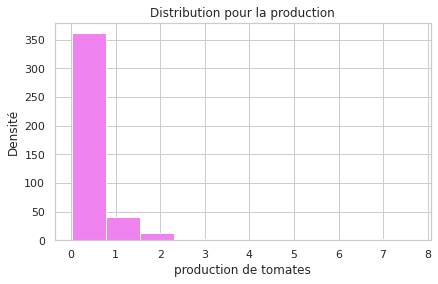

skew= 5.583569472053098


In [12]:
plt.hist(Pop['Production quantité \ntonne(s)'],color ='violet')
plt.title('Distribution pour la production')
plt.xlabel('production de tomates')
plt.ylabel('Densité')
plt.show()
print ("skew=", Pop['Production quantité \ntonne(s)'].skew())

On reamrque que la production moyenne est d'envion 0.4646 tonnes, avec des valeurs comprises entre 0.016 tonnes et 7.680 tonnes.

In [13]:
Pop['catégorie tomates'].value_counts().to_frame()

,catégorie tomates
Tomate ronde cat.I 57-67mm,372
Tomate ronde cat.I 67-82mm,52


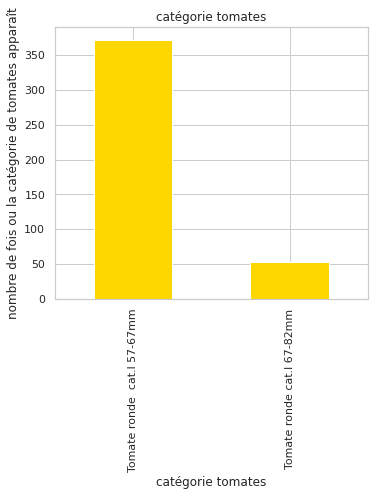

In [14]:
Pop['catégorie tomates'].value_counts().plot(kind='bar',figsize=(5,5),title= 'catégorie tomates',color ='gold')
plt.xlabel('catégorie tomates')
plt.ylabel("nombre de fois ou la catégorie de tomates apparaît")
plt.show()

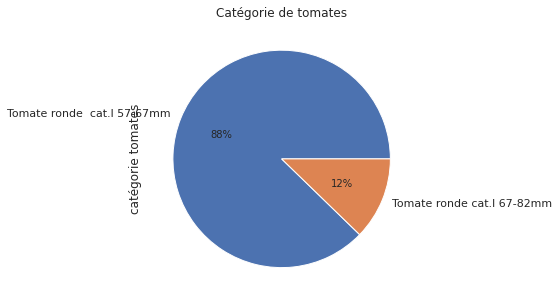

In [15]:
Pop['catégorie tomates'].value_counts().plot(kind='pie', title='Catégorie de tomates', figsize=[5,5],
          autopct=lambda p: '{:.0f}%'.format(p,(p/100)*Pop['catégorie tomates'].value_counts().sum()))

**étude de corrélation**

Ici, on essaye de voir les différentes corrélations qui peuvent être présentes entre les différentes colonnes.

                                   prix moyen au kg  ...  Rafales (vitesse du vent) en km/h
prix moyen au kg                           1.000000  ...                           0.136908
Production quantité \ntonne(s)            -0.240758  ...                          -0.094633
Température minimale en °C                 0.040735  ...                           0.117860
Température maximale en °C                 0.159174  ...                          -0.131305
précipitations en mm                      -0.106323  ...                           0.219804
Ensoleillement en min                      0.199000  ...                          -0.188815
Rafales (vitesse du vent) en km/h          0.136908  ...                           1.000000

[7 rows x 7 columns]


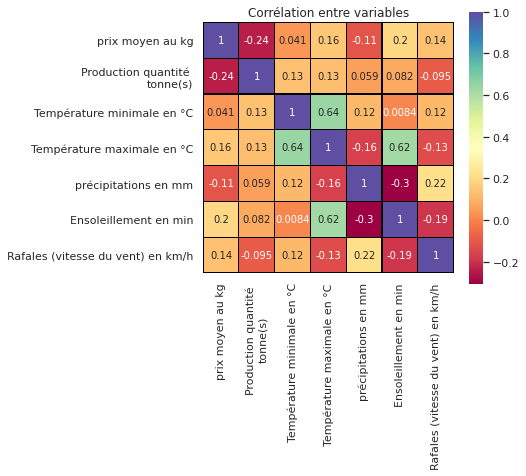

In [16]:
Corr = Pop.corr()
print(Corr)

f, ax = plt.subplots(figsize=(5,5))
plt.title('Corrélation entre variables')


sns.heatmap(Corr,linewidths=0.25,vmax=1.0, square=True, cmap="Spectral", linecolor='black', annot=True)
plt.show()

Parmi les corrélations qui nous intéressent, on remarque que:

le prix est très faiblement corrélé avec les températures maximale et minimale
le prix est très faiblement corrélé avec l'ensoleillement.
la production est très faiblement corrélée avec les températures maximale et minimale
le production est très faiblement corrélée avec l'ensoleillement.

In [17]:
Pop =  Pop.interpolate() #pour remplacer les valeurs nulles par une valeur moyenne
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm


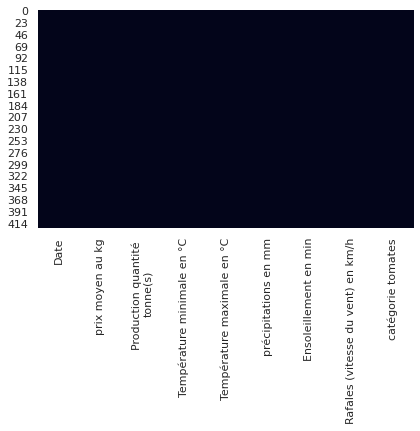

In [18]:
sns.heatmap(Pop.isna(), cbar=False)

**Encodage des catégories de tomates**

In [19]:
dummy_tomate1 = pd.get_dummies(Pop['catégorie tomates'])
dummy_tomate1

,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
419,0,1
420,0,1
421,0,1
422,0,1


In [20]:
T =  pd.merge(
    left=Pop,
    right=dummy_tomate1,
    left_index=True,
    right_index=True,
)

T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm,1,0
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm,1,0
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm,1,0
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm,1,0
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm,1,0
...,...,...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm,0,1
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm,0,1
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm,0,1
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm,0,1


In [21]:
T = T.drop(["catégorie tomates"], axis=1)
T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,1,0
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,1,0
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,1,0
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,1,0
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,1,0
...,...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,0,1
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,0,1
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,0,1
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,0,1


**Modèle**

In [22]:
T['Date'] = pd.to_datetime(T['Date'],infer_datetime_format=True) 
T = T.set_index(['Date'])
T

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
Date,,,,,,,,,
2021-06-21,1.50,0.200,15.7,24.9,3.8,423,61.2,1,0
2020-04-12,1.50,0.100,2.9,6.6,0.8,256,65.9,1,0
2020-06-11,1.10,0.100,2.3,13.4,0.0,491,46.8,1,0
2020-05-11,1.10,0.100,1.8,11.5,0.0,533,32.4,1,0
2020-10-30,1.05,0.100,12.6,15.9,0.0,0,40.7,1,0
...,...,...,...,...,...,...,...,...,...
2013-06-24,1.10,1.120,10.5,19.1,0.0,342,42.6,0,1
2013-06-20,1.50,0.075,14.0,21.5,0.8,216,37.1,0,1
2013-06-17,1.50,0.020,15.0,27.2,6.8,210,61.1,0,1


In [23]:
Prix = T['prix moyen au kg'] 
Production = T['Production quantité \ntonne(s)'] 

**Modèle linéaire**

In [24]:
#pour le prix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X =  T.drop(['prix moyen au kg'], axis=1)
y = Prix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)
model.score(X_test, y_test)

0.2599233721145574

In [26]:
y_pred = model.predict(X_test)

In [27]:
R2Plr = r2_score(y_test, y_pred)
R2Plr

0.2599233721145574

In [29]:
from math import sqrt
rmseP1T1LR =sqrt(mean_squared_error(y_test, y_pred))
print(rmseP1T1LR)

0.2596529641967126


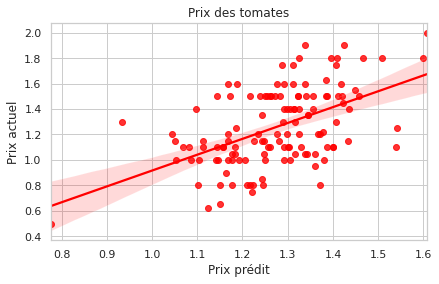

In [30]:
sns.regplot(y_pred,y_test, color ='red')
plt.title('Prix des tomates')
plt.xlabel('Prix prédit')
plt.ylabel('Prix actuel')
plt.show()

In [31]:
#pour la production


from sklearn.model_selection import train_test_split

X2 =  T.drop("Production quantité \ntonne(s)", axis=1)
y2 = Production

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [32]:
model = lr.fit(X_train, y_train)
model.score(X_test, y_test)

0.17579375322084967

In [33]:
y_pred = model.predict(X_test)

In [34]:
R2Polr = r2_score(y_test, y_pred)
R2Polr

0.17579375322084967

In [35]:
rmsePO1T1LR =sqrt(mean_squared_error(y_test, y_pred))
print(rmsePO1T1LR)

0.7803873673145253


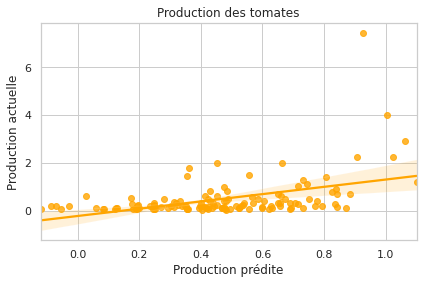

In [37]:
sns.regplot(y_pred,y_test, color ='orange')
plt.title('Production des tomates')
plt.xlabel('Production prédite')
plt.ylabel('Production actuelle')
plt.show()

**Random forest**

In [39]:
# pour le prix
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
forest_reg.score(X_test, y_test)

0.26037919066469406

In [40]:
y_pred = forest_reg.predict(X_test)

rmserfP1T1 = (np.sqrt(mean_squared_error(y_test, y_pred)))
rmserfP1T1

0.2595729908110507

In [41]:
R2Prf = r2_score(y_test, y_pred)
R2Prf

0.26037919066469406

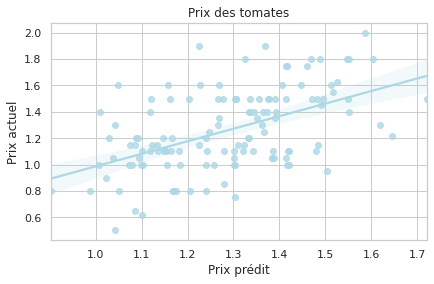

In [42]:
sns.regplot(y_pred,y_test, color ='lightblue')
plt.title('Prix des tomates')
plt.xlabel('Prix prédit')
plt.ylabel('Prix actuel')
plt.show()

In [43]:
# Pour la production

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
forest_reg.score(X_test, y_test)

0.09797538898688718

In [44]:
y_pred = forest_reg.predict(X_test)

rmserfPO1T1 = (np.sqrt(mean_squared_error(y_test, y_pred)))
rmserfPO1T1

0.8163971373041662

In [45]:
R2Porf = r2_score(y_test, y_pred)
R2Porf

0.09797538898688718

Le RMSE est proche de 1.

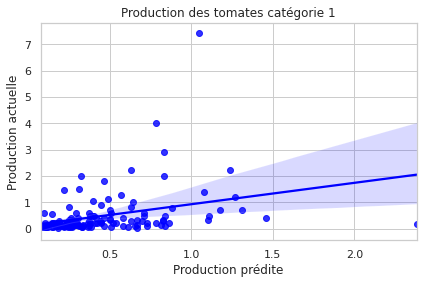

In [46]:
sns.regplot(y_pred,y_test, color ='blue')
plt.title('Production des tomates catégorie 1')
plt.xlabel('Production prédite')
plt.ylabel('Production actuelle')
plt.show()